In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Laoding Data

In [5]:
filename = "C:/Users/RYuK/trainingText (2).txt"

In [15]:
text = open(filename, 'r', encoding='utf-8').read()
text = ''.join(a for a in text if not a.isdigit())
text = text.replace('\n',' ')
text = text.lower()
text

'supposing that truth is a woman--what then? is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women--that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth, have been unskilled and unseemly methods for winning a woman? certainly she has never allowed herself to be won; and at present every kind of dogma stands with sad and discouraged mien--if, indeed, it stands at all! for there are scoffers who maintain that it has fallen, that all dogma lies on the ground--nay more, that it is at its last gasp. but to speak seriously, there are good grounds for hoping that all dogmatizing in philosophy, whatever solemn, whatever conclusive and decided airs it has assumed, may have been only a noble puerilism and tyronism; and probably the time is at hand when it will be once and again understood what has actually sufficed for the basis of such imposing and absolute phil

In [4]:
print('Length of the corpus:', len(text))

Length of the corpus: 216110


# Data Precprocessing

In [5]:
#Total number of unique character presents in corpus
chars = sorted(list(set(text)))
print(chars)
print('-'*120)
print('Total number of character in corpus:', len(chars))

[' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
------------------------------------------------------------------------------------------------------------------------
Total number of character in corpus: 41


In [17]:
# Saving the chars variable to use it for the prediciton 

with open('chars.pckl', 'wb') as fp:
    pickle.dump(chars, fp)

In [6]:
# Creating Character-Index Map to use it as Tokens for the training and the predictions.

#Creating a dictionary of characters mapped to integer value.
char_index = dict((c, i) for i, c in enumerate(chars))

#And reverse to print our prediction in characters and not in integers.
index_char = dict((i, c) for i, c in enumerate(chars))

In [18]:
# Saving the dictionary to use for prediciton
np.save('char_index.npy', char_index)
np.save('index_char.npy', index_char)

In [7]:
print('Character to Integer Mapping:\n',char_index)
print('-'*120)
print('Index to Character Mapping:\n',index_char)

Character to Integer Mapping:
 {' ': 0, '!': 1, '"': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, '[': 12, ']': 13, '_': 14, 'a': 15, 'b': 16, 'c': 17, 'd': 18, 'e': 19, 'f': 20, 'g': 21, 'h': 22, 'i': 23, 'j': 24, 'k': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'w': 37, 'x': 38, 'y': 39, 'z': 40}
------------------------------------------------------------------------------------------------------------------------
Index to Character Mapping:
 {0: ' ', 1: '!', 2: '"', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: ':', 10: ';', 11: '?', 12: '[', 13: ']', 14: '_', 15: 'a', 16: 'b', 17: 'c', 18: 'd', 19: 'e', 20: 'f', 21: 'g', 22: 'h', 23: 'i', 24: 'j', 25: 'k', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'w', 38: 'x', 39: 'y', 40: 'z'}


In [8]:
# Since LSTM input and ouput can be sequences, Lets create input/output sequences for training
seq_len = 40
step = 2
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len])
    next_chars.append(text[i + seq_len])
print('Number of Training sequences:', len(sentences))

Number of Training sequences: 108035


# Feature Extraction

In [9]:
# Now to generate Features and lables, we will convert the above Sequence and character to One-hot coded vectors using
# the character index map.

X = np.zeros((len(sentences), seq_len, len(chars)), dtype=np.bool)
Y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for a, sentence in enumerate(sentences):
    for b, char in enumerate(sentence):
        X[a, b, char_index[char]] = 1
        Y[a, char_index[next_chars[a]]] = 1

print('Shape of X:', X.shape)
print('Shape of Y:',Y.shape)

Shape of X: (108035, 40, 41)
Shape of Y: (108035, 41)


In [10]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False])

In [11]:
Y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

# Model Training

In [13]:
# Using a simple LSTM model with only one hidden layer with 128 neurons and softmax function for activation
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

In [14]:
# Compiling the model with RMSprop optimizer and loss as categorical_crossentropy.
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               87040     
_________________________________________________________________
dense (Dense)                (None, 41)                5289      
Total params: 92,329
Trainable params: 92,329
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Training Model with 20 epochs with validation split of 0.05 and batch_size of 128
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
802/802 [==============================] - 36s 40ms/step - loss: 2.3911 - accuracy: 0.3188 - val_loss: 1.7523 - val_accuracy: 0.4798
Epoch 2/20
802/802 [==============================] - 28s 35ms/step - loss: 1.7126 - accuracy: 0.4901 - val_loss: 1.5891 - val_accuracy: 0.5278
Epoch 3/20
802/802 [==============================] - 28s 35ms/step - loss: 1.5469 - accuracy: 0.5365 - val_loss: 1.5200 - val_accuracy: 0.5526
Epoch 4/20
802/802 [==============================] - 28s 35ms/step - loss: 1.4513 - accuracy: 0.5642 - val_loss: 1.4966 - val_accuracy: 0.5631
Epoch 5/20
802/802 [==============================] - 28s 35ms/step - loss: 1.3848 - accuracy: 0.5804 - val_loss: 1.4884 - val_accuracy: 0.5572
Epoch 6/20
802/802 [==============================] - 27s 34ms/step - loss: 1.3444 - accuracy: 0.5936 - val_loss: 1.4761 - val_accuracy: 0.5607
Epoch 7/20
802/802 [==============================] - 28s 35ms/step - loss: 1.3124 - accuracy: 0.5991 - val_loss: 1.4834 - val_accuracy:

In [19]:
# Saving our model progress
model.save('WTP_model.h5')
pickle.dump(history , open("WTPhistory.p", "wb"))

# Model Evaluation

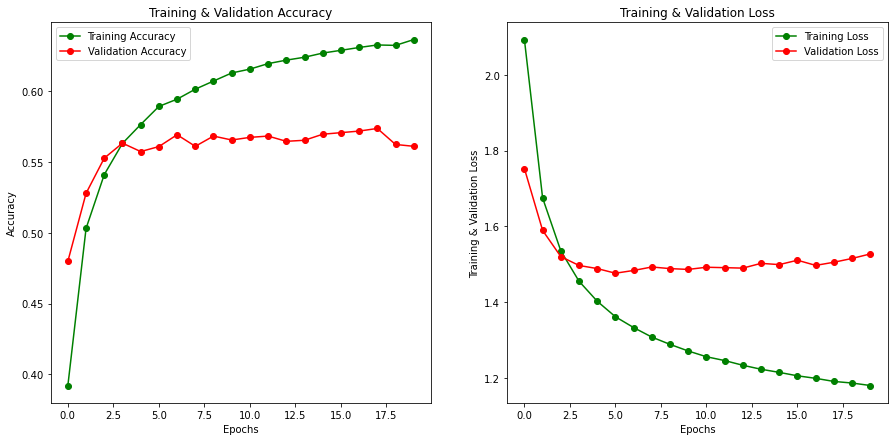

In [16]:
epochs = [i  for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
fig.set_size_inches(15,7)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

As we can see in graph, the graph here represents the each epoch at each nodes and after ssing the graph we can inference that increasing epoch will only overfit our model as the validation accuracy is decreasing with each epochs. So its best time to stop the training.